---

## HW01 AutoEncoder (TensorFlow2)

다음을 확인하는 리포트를 Colab 노트북을 이용해 작성한다.

1. 정규분포를 통한 파라미터 초기화를 진행한 `Dense` layer를 Xavier 초기화, He 초기화 기법을 통해 초기화를 진행한 뒤, 결과에 대해 분석한다.

2. Autoencoder의 encoder를 거쳐 나온 representation $z$를 groud truth(GT) label별로 다른색을 주어 $z$의 분포를 가시화한다.

3. $z$의 분포를 보고 encoder가 label별로 discriminative한 representation을 만들어내는지 확인한다.

4. 만일 discriminative하지 않다면, autoencoder가 discriminative한 representation $z$를 학습하도록 $z$의 차원을 바꿔가면서 실험해본다.

5. $z$ 공간의 임의의 위치를 sampling한 후, 학습된 decoder의 입력으로 주는 방식으로 generative model을 구축한다. <br/>
의미있게 만들어진 이미지는 어떤 특징을 갖고 있는지 논의한다.

6. Autoencoder의 `Dense` layer를 `Conv` layer로 수정하여 실험을 진행한다.

---

# 오토인코더 (TensorFlow 2)
텐서플로우 2에서 제공하는 고수준 API인 케라스를 이용해, 오토인코더(autoencoder)를 구현한다.
* Google Colab 환경에서 사용하는 경우에  초점을 맞춤.
* 텐서플로우 2
* 텐서플로우 2 내장 케라스 기준

참고문헌
* [TensorFlow 소개](https://www.tensorflow.org/learn)
* [TensorFlow > 학습 > TensorFlow Core > 가이드 > 케라스: 빠르게 훑어보기](https://www.tensorflow.org/guide/keras/overview)
* [Deep Learning with Python, by Francois Chollet](https://github.com/fchollet/deep-learning-with-python-notebooks)


주의사항
* Colab에서 코드에 이상이 없음에도 불구하고 결과가 제대로 나오지 않을 경우, '런타임 다시 시작...'을 해보도록 한다.'


## Deep Neural Network 기초
다음 비디오를 보고 심층신경망(deep neural network) 기반 딥러닝 기법은 이해하도록 한다.
* [신경망이란 무엇인가? | 1장.딥러닝에 관하여 (3Blue1Brown)](https://youtu.be/aircAruvnKk)
* [경사 하강, 신경 네트워크가 학습하는 방법 | 심층 학습, 2장 (3Blue1Brown)](https://youtu.be/IHZwWFHWa-w)
* [What is backpropagation really doing? | Deep learning, chapter 3 (3Blue1Brown)](https://youtu.be/Ilg3gGewQ5U)
* [Backpropagation calculus | Deep learning, chapter 4 (3Blue1Brown)](https://youtu.be/tIeHLnjs5U8)


## Tensorflow 2과 Keras를 사용하기 위한 구성
```
import tensorflow as tf                       # 텐서플로우 임포트
from tensorflow.keras import models, layers   # 케라스 관련 모듈 임포트
import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)        # 텐서플로우 버전을 확인하도록 한다.
print(tf.keras.__version__)  # 케라스 버전을 확인한다.
```

In [1]:
import tensorflow as tf                       # 텐서플로우 임포트
import tensorflow_datasets as tfds            # 텐서플로우 데이터셋 임포트
from tensorflow.keras import models, layers   # 케라스 관련 모듈 임포트

import numpy as np
import matplotlib.pyplot as plt
 
print(tf.__version__)        # 텐서플로우 버전을 확인하도록 한다.
print(tf.keras.__version__)  # 케라스 버전을 확인한다.

2.11.0
2.11.0


In [2]:
num_epochs = 10
batch_size = 100
n_dim = 2

## MNIST 데이터셋 띄우기
![MnistExamples.png](https://upload.wikimedia.org/wikipedia/commons/2/27/MnistExamples.png)
* mnist 데이터셋은 숫자(digit) 손글씨 데이터셋이다.
* 60,000개의 트레이닝 데이터와 10,000개의 테스트 데이터로 이루어져 있다.
* LeCun이 자신의 연구에서 활용하고 배포한 데이터셋이 있으나 최근 보편적으로 많이 활용하기 때문에 텐서플로우나 파이토치 등에서 built-in 데이터셋의 형태로 제공해 주기도 한다.  


### MNIST 이미지 데이터
* MNIST 데이터셋은 여러 버젼이 있으나, 여기서는 이를 텐서플로우에 맞게 정리하여 tensorflow_datasets에서 built-in으로 제공하는 데이터셋을 쓰도록 하겠다. ([link](https://www.tensorflow.org/datasets/catalog/mnist)) 
  + (image, label)로 구성된 데이터를 제공.
  + image는 각 픽셀이 [0, 255] 사이값으로 구성된 H x W x C 크기의 이미지이다.
* 뉴럴넷의 입력으로 넣기 위해 픽셀값이 0 근처에 있는 작은 실수값을 가지도록 다음과 같이 변환한다.
  + [0, 255] 사이 값을 [0.0, 1.0] 사이값으로 float32형으로 정규화시킨다.


In [3]:
# MNIST 데이터 로딩
train_images, train_labels = tfds.as_numpy(tfds.load('mnist', split='train', batch_size=-1, as_supervised=True))
test_images, test_labels = tfds.as_numpy(tfds.load('mnist', split='test', batch_size=-1, as_supervised=True))

# Normalizing the images to the range of [0., 1.]
train_images = tf.cast(train_images, tf.float32) / 255.0
test_images = tf.cast(test_images, tf.float32) / 255.0

Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


## 데이터셋 확인
데이터셋을 로딩한 후 **데이터셋 구성**이 어떻게 되어 있는지 **반드시 확인**하는 습관을 가지도록 한다.

torchvision.datasets.MNIST 데이터셋의 각 데이터는 (이미지, 레이블)로 구성된 튜플이다. 

다음은 MNIST 데이터셋에 있는 이미지와 레이블에 대한 각종 정보를 확인하는 코드이다. 

해당 코드를 통해 다음 사항을 확인할 수 있다.
* train_dataset의 길이는 60,000이다. 
* test_dataset의 길이는 10,000이다.

### MNIST 이미지 데이터
* 각 이미지는 H x W X C 순서로 구성된 [28, 28, 1] 모양의 텐서로 로딩되었다.
* 각 이미지 픽셀값은 [0.0, 1.0] 사이의 값으로 변환되었다.
* 각 이미지 픽셀값은 `float32` 타입이다.

### MNIST 라벨 데이터
* 각 레이블 값은 [0, 9] 사이의 `int64`형이다.

In [4]:
def print_MNIST_dataset_info(images, labels):
  print(">>> dataset length: ", len(labels))
  first_img, first_label = images[0], labels[0]
  print(">>> image shape: ", first_img.shape)
  print(">>> image dtype: ", first_img.dtype)
  print(">>> image pixel min-value: ", tf.reduce_min(first_img))
  print(">>> image pixel max-value: ", tf.reduce_max(first_img))
  print(">>> label data type: ", type(first_label))

print("train dataset")
print_MNIST_dataset_info(train_images, train_labels)

print("test dataset")
print_MNIST_dataset_info(test_images, test_labels)

train dataset
>>> dataset length:  60000
>>> image shape:  (28, 28, 1)
>>> image dtype:  <dtype: 'float32'>
>>> image pixel min-value:  tf.Tensor(0.0, shape=(), dtype=float32)
>>> image pixel max-value:  tf.Tensor(1.0, shape=(), dtype=float32)
>>> label data type:  <class 'numpy.int64'>
test dataset
>>> dataset length:  10000
>>> image shape:  (28, 28, 1)
>>> image dtype:  <dtype: 'float32'>
>>> image pixel min-value:  tf.Tensor(0.0, shape=(), dtype=float32)
>>> image pixel max-value:  tf.Tensor(1.0, shape=(), dtype=float32)
>>> label data type:  <class 'numpy.int64'>


### 첫번째 배치의 첫번째 이미지와 레이블 확인
첫 이미지와 해당 레이블을 찍어서 확인해 보자.


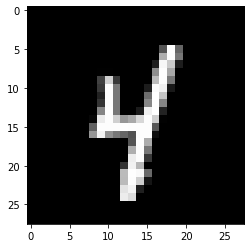

In [5]:
import matplotlib.pyplot as plt

img = train_images[0]

plt.figure()
plt.imshow(img, cmap='gray')

## 네트워크 모델 설계
* 인코더 모델: 케라스 시퀀셜 모델로 설계
  + InputLayer로 (28, 28, 1) 영상을 받고, 출력으로 n_dim차원 벡터가 나오도록 함.
* 디코더 모델: 케라스 시퀀셜 모델로 설계
  + InputLayer에서 n_dim차원 벡터를 받고, 출력으로 (28, 28, 1) 영상이 나오도록 함.
* 오토인코더 모델: 인코더, 디코더를 결합하여 설계

## TODO

1. encoder, decoder 부분을 수정하여 `Xavier` 또는 `He Initialization`을 적용하여 파라미터를 초기화한 후 학습을 진행해본다. [Xavier, He initialization 설명](https://reniew.github.io/13/)
  * 힌트: `Dense()`모듈을 살펴본다.

2. 결과에 대한 분석을 작성한다.

인코더 모델 정의
* (28, 28, 1) 영상을 입력으로 받도록 입력 레이어 정의
* Flatten으로 입력 텐서를 784-vector로 벡터라이즈
* Fully connected layer로 784 > 256 > 128 > 32 > n_dim 로 차원 축소

# TODO 1.
Xavier 초기값
- Xavier 초기값 설정은 신경망의 가중치를 초기화하는 방법 중 하나로  앞 층의 입력 노드 수와 다음 층의 출력 노드 수를 고려하여 가중치의 분포를 결정한다.
이 방법은 활성화 함수로 시그모이드나 하이퍼볼릭 탄젠트를 사용할 때 효과적이다.

HE 초기값
- He 정규분포 방식으로 파라미터의 초기값을 생성합니다. 가중치 텐서의 크기에 따라 값을 조절하는 방식의 하나


In [6]:
## TODO

'''
Xavier 초기값 설정은 신경망의 가중치를 초기화하는 방법 중 하나로  앞 층의 입력 노드 수와 다음 층의 출력 노드 수를 고려하여 가중치의 분포를 결정한다.
이 방법은 활성화 함수로 시그모이드나 하이퍼볼릭 탄젠트를 사용할 때 효과적이다.
ReLu 사용 시 He 초기화 방법을 사용해야 한다.
https://github.com/keras-team/keras-docs-ko/blob/master/sources/initializers.md
'''

# Xavier Initialization
Xavier = tf.keras.initializers.GlorotNormal(seed=20)

# He Initialization
He = tf.keras.initializers.he_normal(seed=20)

In [7]:
enc = tf.keras.models.Sequential([
  tf.keras.layers.InputLayer(input_shape=(28, 28, 1)),
  tf.keras.layers.Flatten(),    # 784 = 28 x 28 x 1
  tf.keras.layers.Dense(256, activation='relu', kernel_initializer=Xavier),
  tf.keras.layers.Dense(128, activation='relu', kernel_initializer=Xavier),
  tf.keras.layers.Dense( 32, activation='relu', kernel_initializer=Xavier),
  tf.keras.layers.Dense(n_dim),  
])

디코더 모델 정의
* Fully connected layey로 n_dim > 32 > 128 > 256 > 784로 차원 확대
* 784-vector를 Reshape을 통해 (28, 28, 1)의 텐서로 변환

In [8]:
dec = tf.keras.models.Sequential([
  tf.keras.layers.InputLayer(input_shape=(n_dim,)),   # 주의: 반드시 1D tensor를 (ndim, )로 표현할 것
  tf.keras.layers.Dense( 32, activation='relu', kernel_initializer=Xavier),
  tf.keras.layers.Dense(256, activation='relu', kernel_initializer=Xavier),
  tf.keras.layers.Dense(784, activation='sigmoid', kernel_initializer=Xavier),   # 문제의 특성상, logit을 바로 쓰지 않고 sigmod 활성화 함수 사용함
  tf.keras.layers.Reshape(target_shape=(28, 28, 1)),
])

AutoEncoder 모델 정의
* (28, 28, 1) 영상을 입력으로 받도록 입력 레이어 정의
* 입력 레이어 > 인코더 > 디코더로 구성

In [9]:
ae = tf.keras.models.Sequential([
  tf.keras.layers.InputLayer(input_shape=(28, 28, 1)),   # 입력 구조를 명확히 보여주기 위해, input layer (재)정의
  enc,
  dec,                               
])

## 훈련 전, 네트워크 모델을 함수로서 활용
* AutoEncoder ae를 모델로 구성했기 때문에, 지금부터 함수로서 활용 가능 [(효과적인 TensorFlow: 세션 대신 함수)](https://www.tensorflow.org/guide/effective_tf2?hl=ko#%EC%84%B8%EC%85%98_%EB%8C%80%EC%8B%A0_%ED%95%A8%EC%88%98)
  + 단, ae 함수는 batch 단위로 수행됨을 명심할 것.  
    - 단순히, (28, 28, 1) -> ae -> (28, 28, 1)로 동작하지 않고,
    - batch 단위로 (?, 28, 28, 1) -> ae -> (?, 28, 28, 1)로 병렬처리됨.
* 지금은 훈련 전 네트웍이기 때문에 정상적으로 작동하지 않음.

In [10]:
y_pred = ae(train_images)
print('input  shape:', train_images.shape)
print('output shape:', y_pred.shape)

input  shape: (60000, 28, 28, 1)
output shape: (60000, 28, 28, 1)


## 네트워크 모델 구조 확인
* summary() 함수로 모델의 구조를 텍스트로 프린트할 수 있음.
* plot_model() 함수로 모델의 구조를 텍스트로 프린트할 수 있음.

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 256)               200960    
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 32)                4128      
                                                                 
 dense_3 (Dense)             (None, 2)                 66        
                                                                 
Total params: 238,050
Trainable params: 238,050
Non-trainable params: 0
_________________________________________________________________


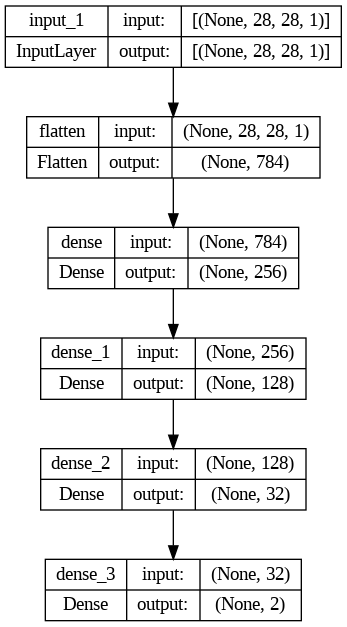

In [11]:
enc.summary()
tf.keras.utils.plot_model(enc, 'enc.png', show_shapes=True)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 32)                96        
                                                                 
 dense_5 (Dense)             (None, 256)               8448      
                                                                 
 dense_6 (Dense)             (None, 784)               201488    
                                                                 
 reshape (Reshape)           (None, 28, 28, 1)         0         
                                                                 
Total params: 210,032
Trainable params: 210,032
Non-trainable params: 0
_________________________________________________________________


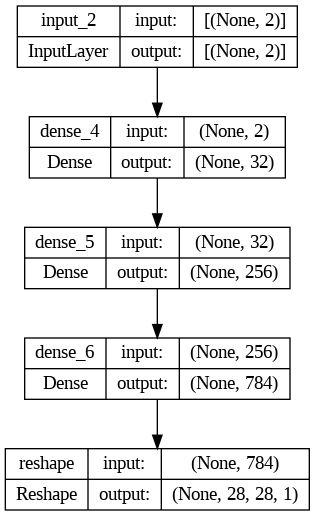

In [12]:
dec.summary()
tf.keras.utils.plot_model(dec, 'dec.png', show_shapes=True)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 2)                 238050    
                                                                 
 sequential_1 (Sequential)   (None, 28, 28, 1)         210032    
                                                                 
Total params: 448,082
Trainable params: 448,082
Non-trainable params: 0
_________________________________________________________________


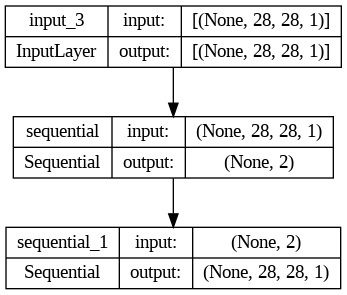

In [13]:
ae.summary()
tf.keras.utils.plot_model(ae, 'ae.png', show_shapes=True)

## 훈련 전, 네트워크 모델을 함수로서 활용
* AutoEncoder ae를 모델로 구성했기 때문에, 지금부터 함수로서 활용 가능 
  + 단, ae 함수는 batch 단위로 수행됨을 명심할 것.  
    - 단순히, (1, 28, 28) -> ae -> (1, 28, 28)로 동작하지 않고,
    - batch 단위로 (?, 1, 28, 28) -> ae -> (?, 1, 28, 28)로 병렬처리됨.
* 지금은 훈련 전 네트웍이기 때문에 정상적으로 작동하지 않음.

In [14]:
import ipywidgets as widgets

def train_dataset_imshow(idx):
  print('GT label:', train_labels[idx])

  X      = tf.expand_dims(train_images[idx], 0)  # (28, 28, 1) -> (1, 28, 28, 1)
  Y_pred = ae(X) 

  input_img  = tf.keras.utils.array_to_img(tf.squeeze(X, 0))
  output_img = tf.keras.utils.array_to_img(tf.squeeze(Y_pred, 0))

  plt.subplot(121)
  plt.imshow(input_img, cmap='gray')
  plt.subplot(122)
  plt.imshow(output_img, cmap='gray')
  plt.show()

widgets.interact(train_dataset_imshow, idx=widgets.IntSlider(min=0, max=train_images.shape[0]-1, continuous_update=False));

interactive(children=(IntSlider(value=0, continuous_update=False, description='idx', max=59999), Output()), _d…

## 오토인코더 인스턴스 트레이닝

AutoEncoder 인스턴스 ae에 대한 훈련 수행
* 인스턴스 ae를 [compile](https://www.tensorflow.org/api_docs/python/tf/keras/Model#compile)
  + cf) shader program 컴파일과 유사하게 이해해도 됨
  + 이때, 훈련에 활용될 [optimizer](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers), [loss](https://www.tensorflow.org/api_docs/python/tf/keras/losses), [metrics](https://www.tensorflow.org/api_docs/python/tf/keras/metrics) 등을 지정함
  + Optmizer에 대한 이론적 내용은 [이곳](https://brunch.co.kr/@chris-song/50)을 참고하세요.

<br/>

* `train_images`를 입력과 대상으로 사용하여 모델을 훈련
* encoder: dataset을 784차원에서 `n_dim`차원의 latent space로 압축하는 방법을 학습
* decoder: 원본 이미지를 재구성하는 방법을 학습

In [15]:
print(np.shape(train_images))
ae.compile(optimizer='Adam', # optimizer의 name 혹은 함수 객체 설정
           loss='mse', 
           metrics=['mae'])

ae.fit(train_images, train_images, epochs=num_epochs, batch_size=batch_size)

(60000, 28, 28, 1)
Epoch 1/10
600/600 [==============================] - 5s 3ms/step - loss: 0.0615 - mae: 0.1338
Epoch 2/10
600/600 [==============================] - 2s 3ms/step - loss: 0.0477 - mae: 0.1085
Epoch 3/10
600/600 [==============================] - 2s 3ms/step - loss: 0.0436 - mae: 0.1009
Epoch 4/10
600/600 [==============================] - 2s 3ms/step - loss: 0.0417 - mae: 0.0974
Epoch 5/10
600/600 [==============================] - 2s 3ms/step - loss: 0.0406 - mae: 0.0954
Epoch 6/10
600/600 [==============================] - 2s 3ms/step - loss: 0.0398 - mae: 0.0939
Epoch 7/10
600/600 [==============================] - 2s 3ms/step - loss: 0.0393 - mae: 0.0929
Epoch 8/10
600/600 [==============================] - 2s 3ms/step - loss: 0.0387 - mae: 0.0919
Epoch 9/10
600/600 [==============================] - 2s 3ms/step - loss: 0.0384 - mae: 0.0913
Epoch 10/10
600/600 [==============================] - 2s 3ms/step - loss: 0.0381 - mae: 0.0907


### 트레이닝셋을 이용해 학습 후 결과 시각화
학습이 끝난 autoencoder에 대해 train_dataset에 대한 결과 시각화

In [16]:
import ipywidgets as widgets

def train_dataset_imshow(idx):
  print('GT label:', train_labels[idx])

  X      = tf.expand_dims(train_images[idx], 0)  # (28, 28, 1) -> (1, 28, 28, 1)
  Y_pred = ae(X) 

  input_img  = tf.keras.utils.array_to_img(tf.squeeze(X, 0))
  output_img = tf.keras.utils.array_to_img(tf.squeeze(Y_pred, 0))

  plt.subplot(121)
  plt.imshow(input_img, cmap='gray')
  plt.subplot(122)
  plt.imshow(output_img, cmap='gray')
  plt.show()

widgets.interact(train_dataset_imshow, idx=widgets.IntSlider(min=0, max=train_images.shape[0]-1, continuous_update=False));

interactive(children=(IntSlider(value=0, continuous_update=False, description='idx', max=59999), Output()), _d…

### 테스트셋을 이용해 학습 후 결과 시각화 
학습이 끝난 autoencoder에 대해 test_dataset에 대한 결과 시각화

In [17]:
import ipywidgets as widgets

def test_dataset_imshow(idx):
  print('GT label:', test_labels[idx])

  X      = tf.expand_dims(test_images[idx], 0)  # (28, 28, 1) -> (1, 28, 28, 1)
  Y_pred = ae(X) 

  input_img  = tf.keras.utils.array_to_img(tf.squeeze(X, 0))
  output_img = tf.keras.utils.array_to_img(tf.squeeze(Y_pred, 0))

  plt.subplot(121)
  plt.imshow(input_img, cmap='gray')
  plt.subplot(122)
  plt.imshow(output_img, cmap='gray')
  plt.show()

widgets.interact(test_dataset_imshow, idx=widgets.IntSlider(min=0, max=test_images.shape[0]-1, continuous_update=False));

interactive(children=(IntSlider(value=0, continuous_update=False, description='idx', max=9999), Output()), _do…

# 인코더 / 디코더 모델을 각각 따로 함수로서 활용하기
오토인코더 네트웍 전체가 아닌 enc() 부분과 dec() 부분을 각각 수행할 수 있다.
* 특정 예제에 대한 인코딩 결과와 디코딩 결과를 따로 확인한다.

In [18]:
z = enc(train_images)
y_pred = dec(z)

print(np.shape(train_images))
print(np.shape(z))
print(np.shape(y_pred))

(60000, 28, 28, 1)
(60000, 2)
(60000, 28, 28, 1)


## 인코딩 결과 확인 및 디코딩 결과 확인
* 특정 이미지에 대한 인코딩 결과를 확인한다.
* 인코딩 결과와 유사한 좌표값을 디코딩에 보내도 유사한 결과가 나옴을 확인한다.

In [19]:
import ipywidgets as widgets

def z_show(idx):
  print(z[idx])
  print('GT label:', train_labels[idx])

widgets.interact(z_show, idx=widgets.IntSlider(min=0, max=train_images.shape[0]-1));

interactive(children=(IntSlider(value=0, description='idx', max=59999), Output()), _dom_classes=('widget-inter…

인코딩 결과와 유사한 좌표값을 디코딩에 보내도 유사한 결과가 나옴을 확인

In [20]:
import ipywidgets as widgets

u=widgets.FloatSlider(min=-5.0, max=5.0)
v=widgets.FloatSlider(min=-5.0, max=5.0)

ui = widgets.HBox([u,v])

def z_test(u, v):
  z_test = np.array([[u,v]])  
  print(z_test)

  img_gen = dec(z_test)
  plt.imshow(img_gen[0], cmap='gray')
  plt.show()  

out = widgets.interactive_output(z_test, {'u': u, 'v': v})

display(ui, out)

Output()

## TODO
1. encoder를 거쳐 나온 representation z를 GT label 별로 다른색을 주어 z의 분포를 가시화한다.
2. z의 분포를 보고 encoder가 label 별로 discriminative한 representation을 만들어내는지 여부를 확인한다.
3. 만일 discriminative하지 않다면, autoencoder가 discriminative한 representation z를 학습하도록 z의 차원을 바꿔가면서 실험을 진행한다.
4. 결과에 대한 분석을 작성한다.

## 인코딩 결과 가시화
오토인코더의 encoder가 만들어 내는 representation인 z 값을 가시화 한다. 

# TODO 2.
z값을 가시화
- z는 input으로 들어간 데이터가 Encoder를 지나 데이터의 특징이 압축되어 있는 공간이다. 현재 z는 10000개의 테스터 데이터가 들어가 각각의 데이터들은 2차원의 차원으로 특징들이 축소(압축)되어 있다


In [21]:
z = enc(test_images)
print(z.shape)

(10000, 2)


(980, 2)
(1135, 2)
(1032, 2)
(1010, 2)
(982, 2)
(892, 2)
(958, 2)
(1028, 2)
(974, 2)
(1009, 2)


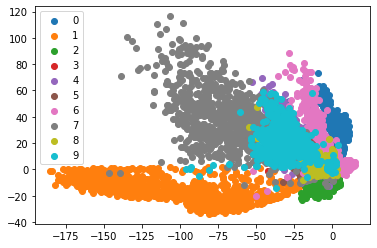

In [22]:
# 로딩된 MNIST 데이터 가시화
import matplotlib.pyplot as plt


## TODO
z = enc(test_images)
colors = plt.cm.tab10(range(10))

z_0 = z[test_labels==0]    # z 배열을 조건을 이용해 slice
z_1 = z[test_labels==1]
z_2 = z[test_labels==2]
z_3 = z[test_labels==3]
z_4 = z[test_labels==4]
z_5 = z[test_labels==5]
z_6 = z[test_labels==6]
z_7 = z[test_labels==7]
z_8 = z[test_labels==8]
z_9 = z[test_labels==9]

print(z_0.shape)
print(z_1.shape)
print(z_2.shape)
print(z_3.shape)
print(z_4.shape)
print(z_5.shape)
print(z_6.shape)
print(z_7.shape)
print(z_8.shape)
print(z_9.shape)

plt.scatter(z_0[:,0], z_0[:,1], color=colors[0], label='0')
plt.scatter(z_1[:,0], z_1[:,1], color=colors[1], label='1')
plt.scatter(z_2[:,0], z_2[:,1], color=colors[2], label='2')
plt.scatter(z_3[:,0], z_3[:,1], color=colors[3], label='3')
plt.scatter(z_4[:,0], z_4[:,1], color=colors[4], label='4')
plt.scatter(z_5[:,0], z_5[:,1], color=colors[5], label='5')
plt.scatter(z_6[:,0], z_6[:,1], color=colors[6], label='6')
plt.scatter(z_7[:,0], z_7[:,1], color=colors[7], label='7')
plt.scatter(z_8[:,0], z_8[:,1], color=colors[8], label='8')
plt.scatter(z_9[:,0], z_9[:,1], color=colors[9], label='9')
plt.legend()
plt.show()

In [39]:
def dim_change_z(n_dim, initializer):  
  enc = tf.keras.models.Sequential([
  tf.keras.layers.InputLayer(input_shape=(28, 28, 1)),
  tf.keras.layers.Flatten(),    # 784 = 28 x 28 x 1
  tf.keras.layers.Dense(256, activation='relu', kernel_initializer=initializer),
  tf.keras.layers.Dense(128, activation='relu', kernel_initializer=initializer),
  tf.keras.layers.Dense( 32, activation='relu', kernel_initializer=initializer),
  tf.keras.layers.Dense(n_dim),  
  ])
  
  dec = tf.keras.models.Sequential([
  tf.keras.layers.InputLayer(input_shape=(n_dim,)),   # 주의: 반드시 1D tensor를 (ndim, )로 표현할 것
  tf.keras.layers.Dense( 32, activation='relu', kernel_initializer=initializer),
  tf.keras.layers.Dense(256, activation='relu', kernel_initializer=initializer),
  tf.keras.layers.Dense(784, activation='sigmoid', kernel_initializer=initializer),   # 문제의 특성상, logit을 바로 쓰지 않고 sigmod 활성화 함수 사용함
  tf.keras.layers.Reshape(target_shape=(28, 28, 1)),
  ])
  return enc, dec

import matplotlib.pyplot as plt

def visual_dim(z):
  colors = plt.cm.tab10(range(10))

  z_0 = z[test_labels==0]    # z 배열을 조건을 이용해 slice
  z_1 = z[test_labels==1]
  z_2 = z[test_labels==2]
  z_3 = z[test_labels==3]
  z_4 = z[test_labels==4]
  z_5 = z[test_labels==5]
  z_6 = z[test_labels==6]
  z_7 = z[test_labels==7]
  z_8 = z[test_labels==8]
  z_9 = z[test_labels==9]

  print(z_0.shape)
  print(z_1.shape)
  print(z_2.shape)
  print(z_3.shape)
  print(z_4.shape)
  print(z_5.shape)
  print(z_6.shape)
  print(z_7.shape)
  print(z_8.shape)
  print(z_9.shape)

  plt.scatter(z_0[:,0], z_0[:,1], color=colors[0], label='0')
  plt.scatter(z_1[:,0], z_1[:,1], color=colors[1], label='1')
  plt.scatter(z_2[:,0], z_2[:,1], color=colors[2], label='2')
  plt.scatter(z_3[:,0], z_3[:,1], color=colors[3], label='3')
  plt.scatter(z_4[:,0], z_4[:,1], color=colors[4], label='4')
  plt.scatter(z_5[:,0], z_5[:,1], color=colors[5], label='5')
  plt.scatter(z_6[:,0], z_6[:,1], color=colors[6], label='6')
  plt.scatter(z_7[:,0], z_7[:,1], color=colors[7], label='7')
  plt.scatter(z_8[:,0], z_8[:,1], color=colors[8], label='8')
  plt.scatter(z_9[:,0], z_9[:,1], color=colors[9], label='9')
  plt.legend()
  plt.show()

def dim_change_z(n_dim, initializer):  
  enc = tf.keras.models.Sequential([
  tf.keras.layers.InputLayer(input_shape=(28, 28, 1)),
  tf.keras.layers.Flatten(),    # 784 = 28 x 28 x 1
  tf.keras.layers.Dense(256, activation='relu', kernel_initializer=initializer),
  tf.keras.layers.Dense(128, activation='relu', kernel_initializer=initializer),
  tf.keras.layers.Dense( 32, activation='relu', kernel_initializer=initializer),
  tf.keras.layers.Dense(n_dim),  
  ])
  
  dec = tf.keras.models.Sequential([
  tf.keras.layers.InputLayer(input_shape=(n_dim,)),   # 주의: 반드시 1D tensor를 (ndim, )로 표현할 것
  tf.keras.layers.Dense( 32, activation='relu', kernel_initializer=initializer),
  tf.keras.layers.Dense(256, activation='relu', kernel_initializer=initializer),
  tf.keras.layers.Dense(784, activation='sigmoid', kernel_initializer=initializer),   # 문제의 특성상, logit을 바로 쓰지 않고 sigmod 활성화 함수 사용함
  tf.keras.layers.Reshape(target_shape=(28, 28, 1)),
  ])
  return enc, dec

import matplotlib.pyplot as plt

Epoch 1/10
600/600 [==============================] - 4s 3ms/step - loss: 0.0594 - mae: 0.1328
Epoch 2/10
600/600 [==============================] - 2s 3ms/step - loss: 0.0487 - mae: 0.1107
Epoch 3/10
600/600 [==============================] - 2s 3ms/step - loss: 0.0456 - mae: 0.1047
Epoch 4/10
600/600 [==============================] - 2s 3ms/step - loss: 0.0435 - mae: 0.1003
Epoch 5/10
600/600 [==============================] - 2s 3ms/step - loss: 0.0421 - mae: 0.0974
Epoch 6/10
600/600 [==============================] - 2s 3ms/step - loss: 0.0412 - mae: 0.0957
Epoch 7/10
600/600 [==============================] - 2s 3ms/step - loss: 0.0406 - mae: 0.0945
Epoch 8/10
600/600 [==============================] - 2s 3ms/step - loss: 0.0402 - mae: 0.0937
Epoch 9/10
600/600 [==============================] - 2s 3ms/step - loss: 0.0396 - mae: 0.0925
Epoch 10/10
600/600 [==============================] - 2s 3ms/step - loss: 0.0394 - mae: 0.0923
(980, 2)
(1135, 2)
(1032, 2)
(1010, 2)
(982, 2)
(

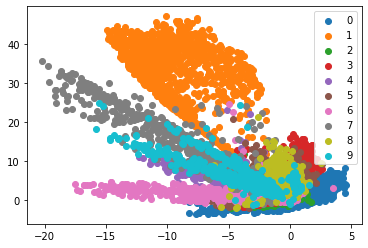

In [45]:
first_dim = 2
second_dim = 4
third_dim = 8
initializer = He

ch_enc, ch_dec = dim_change_z(first_dim, initializer)

ch_ae = ch_ae = tf.keras.models.Sequential([
  tf.keras.layers.InputLayer(input_shape=(28, 28, 1)),   # 입력 구조를 명확히 보여주기 위해, input layer (재)정의
    ch_enc,
    ch_dec,                               
  ])

ch_ae.compile(optimizer='Adam', # optimizer의 name 혹은 함수 객체 설정
           loss='mse', 
           metrics=['mae'])

ch_ae.fit(train_images, train_images, epochs=num_epochs, batch_size=batch_size)

z_first_dim = ch_enc(train_images, first_dim)
y_pred_first_dim = ch_dec(z_first_dim,first_dim)

visual_dim(ch_enc(test_images,first_dim))

Epoch 1/10
600/600 [==============================] - 4s 3ms/step - loss: 0.0490 - mae: 0.1116
Epoch 2/10
600/600 [==============================] - 2s 3ms/step - loss: 0.0357 - mae: 0.0852
Epoch 3/10
600/600 [==============================] - 2s 3ms/step - loss: 0.0334 - mae: 0.0807
Epoch 4/10
600/600 [==============================] - 2s 3ms/step - loss: 0.0321 - mae: 0.0781
Epoch 5/10
600/600 [==============================] - 2s 3ms/step - loss: 0.0312 - mae: 0.0763
Epoch 6/10
600/600 [==============================] - 2s 3ms/step - loss: 0.0305 - mae: 0.0750
Epoch 7/10
600/600 [==============================] - 2s 3ms/step - loss: 0.0299 - mae: 0.0738
Epoch 8/10
600/600 [==============================] - 2s 3ms/step - loss: 0.0294 - mae: 0.0728
Epoch 9/10
600/600 [==============================] - 2s 3ms/step - loss: 0.0289 - mae: 0.0719
Epoch 10/10
600/600 [==============================] - 2s 3ms/step - loss: 0.0285 - mae: 0.0711
(980, 4)
(1135, 4)
(1032, 4)
(1010, 4)
(982, 4)
(

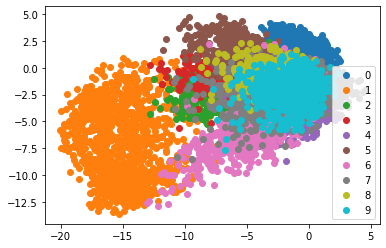

In [46]:
ch_enc, ch_dec = dim_change_z(second_dim, initializer)

ch_ae = ch_ae = tf.keras.models.Sequential([
  tf.keras.layers.InputLayer(input_shape=(28, 28, 1)),   # 입력 구조를 명확히 보여주기 위해, input layer (재)정의
    ch_enc,
    ch_dec,                               
  ])

ch_ae.compile(optimizer='Adam', # optimizer의 name 혹은 함수 객체 설정
           loss='mse', 
           metrics=['mae'])

ch_ae.fit(train_images, train_images, epochs=num_epochs, batch_size=batch_size)

z_second_dim = ch_enc(train_images, second_dim)
y_pred_second_dim = ch_dec(z_second_dim,second_dim)

visual_dim(ch_enc(test_images,second_dim))

Epoch 1/10
600/600 [==============================] - 4s 3ms/step - loss: 0.0407 - mae: 0.0947
Epoch 2/10
600/600 [==============================] - 2s 3ms/step - loss: 0.0265 - mae: 0.0664
Epoch 3/10
600/600 [==============================] - 2s 4ms/step - loss: 0.0241 - mae: 0.0620
Epoch 4/10
600/600 [==============================] - 2s 3ms/step - loss: 0.0227 - mae: 0.0593
Epoch 5/10
600/600 [==============================] - 2s 3ms/step - loss: 0.0218 - mae: 0.0575
Epoch 6/10
600/600 [==============================] - 2s 3ms/step - loss: 0.0211 - mae: 0.0561
Epoch 7/10
600/600 [==============================] - 2s 3ms/step - loss: 0.0206 - mae: 0.0550
Epoch 8/10
600/600 [==============================] - 2s 3ms/step - loss: 0.0202 - mae: 0.0541
Epoch 9/10
600/600 [==============================] - 2s 3ms/step - loss: 0.0198 - mae: 0.0533
Epoch 10/10
600/600 [==============================] - 2s 3ms/step - loss: 0.0195 - mae: 0.0526
(980, 8)
(1135, 8)
(1032, 8)
(1010, 8)
(982, 8)
(

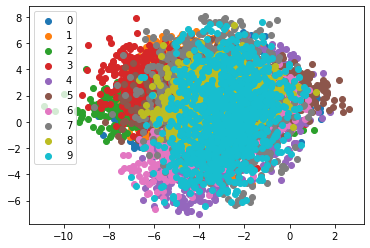

In [47]:
ch_enc, ch_dec = dim_change_z(third_dim, initializer)

ch_ae = ch_ae = tf.keras.models.Sequential([
  tf.keras.layers.InputLayer(input_shape=(28, 28, 1)),   # 입력 구조를 명확히 보여주기 위해, input layer (재)정의
    ch_enc,
    ch_dec,                               
  ])

ch_ae.compile(optimizer='Adam', # optimizer의 name 혹은 함수 객체 설정
           loss='mse', 
           metrics=['mae'])

ch_ae.fit(train_images, train_images, epochs=num_epochs, batch_size=batch_size)

z_third_dim = ch_enc(train_images, third_dim)
y_pred_third_dim = ch_dec(z_third_dim,third_dim)

visual_dim(ch_enc(test_images,third_dim))

## TODO: 디코더를 이용한 Generative Model 구성
1. z 공간의 임의의 위치를 sampling한 후, 이를 decoder의 입력으로 주는 방식으로 generative model을 구축한다.
2. 결과로 만들어지는 이미지는 어떤 특징을 가지고 있는지 분석한다.

# TODO 3.

### 잠재 변수 Z의 임의의 값을 3개 뽑아서 해당 잠재변수를 decoder 모델을 통과시켜 이미지가 제대로 생성 되었는지 확인

1. 잠재 변수 z공간의 임의의 위치 3개를 샘플링
- tensorflow에서 제공하는 random.shuffle함수를 사용하여 섞인 값의 3개의 데이터를 슬라이싱 
2. 랜덤 샘플링한 3개의 잠재 변수(z)를 decoder 모델의 입력값으로 입력
- input_image가 encoder 단계에서 특징을 압축하고 그 압축한 데이터를 펴서 input_image와 유사한 데이터를 생성하는 과정
3. 랜덤으로 생성된 데이터 가시화
- 1 또는 7과같이 직선이 많은 단순한 모델은 어느정도 잘 생성이 되었으나 5와 같이 곡선이 많은 데이터들은 생성이 제대로 되지 않은걸 확인해 볼 수있다. 

In [ ]:
## TODO

#-- 첫 번째 축을 랜덤하게 섞고 앞에서부터 3개의 데이터 슬라이싱
random_samples = tf.random.shuffle(z)[:3]

z = random_samples
result = dec(z)

print(z.shape)
print(result.shape)

(3, 2)
(3, 28, 28, 1)


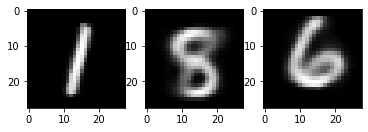

In [ ]:
## TODO

# 로딩된 MNIST 데이터 가시화
import matplotlib.pyplot as plt
cnt = 1
for i in result:
  plt.subplot(1,3,cnt)
  cnt  = cnt +1
  plt.imshow(i, cmap='gray')
plt.show()

## TODO
1. 기존의 `Dense layer`를 `Conv layer`로 변경하여 결과를 확인해본다.
2. `Conv layer`로 변경 후 학습을 진행하고 평가를 진행한다.
3. 결과에 대한 분석을 작성한다.


# TODO 4.
기존 MLP를 Conv Layer로 변경
- Convolution 레이어는 이미지와 같은 데이터를 다루는데 있어 MLP보다 좋은 성능을 보여준다. 

### Enc모델 설계
- Conv2D의 첫 번째 레이어 : 1x28x28 이미지 데이터가 들어오면 해당 이미지를 3x3필터를 사용하여 특징을 추출하며 output으로 16개의 필터를 뽑는다. 필터 연산 이후 활성화 함수 중 하나인 ReLU를 사용하여 해당값에 비선형선을 부여한다.
여기서 ReLU 함수는 Max(0, x)로 0이하의 값들은 모두 0으로 나머지 값들은 그 값 자체를 반환해주어 기울기 소실 문제를 해결한 함수이다.
- MaxPool : 해당 필터에서 나온 값들 중 Max값만을 선택하고 stride(보폭)을 2를 줌으로 해당 크기를 절반으로 작게 만들어 준다 16x14x14
- Conv2D의 두 번째 레이어 : input으로 들어온 16X14X14 데이터를 첫 번째 레이어와 마찬가지로 3x3필터를 사용하여 특징을 추출하여 32x14x14 데이터를 뽑아내고 필터 연산 이후 ReLU함수를 이용하여 비선형성을 부여한다.
- MaxPool : 32x14x14 데이터를 받아 크기를 절반으로 만든다. 32 X 7 x 7
- Dropout(0.25) : Dropout을 이용하여 신경망을 랜덤으로 끊어 overfitting을 방지해준다.
- 최종 Output : 32 x 7 x7 특징 추출

### Dec 모델 설계
Decoder 모델은 위에서 설계 Encoder모델 설계를 역순으로 진행하면 된다.
- Transpose는 컨볼루션 연산과 반대로 작동하며 입력값을 큰 필터로 슬라이딩하며 출력값의 크기를 확대한다.
- Conv2DTranspose 첫 번째 레이어 : 이전 Encoder에 최종 output인 32 x 7 x 7을 입력으로 받아 이미지를 복원한다.
- UpSampling2D : Encoder에 MaxPool과 반대로 이미지를 2배 키워준다. 32X14X14
- Conv2DTranspose 두 번째 레이어 : 이전 레이어의 output을 입력으로 받아 이미지를 16개의 필터 특징으로 복원 16 x 14 x 14
- UpSampling2D : Encoder에 MaxPool과 반대로 이미지를 2배 키워준다. 16 X 28 X 28
- Conv2DTranspose 마지막 레이어 : 이전 레이어의 output을 입력으로 최종 출력을 만든다.  1 X 28 X 28

### 학습
- 옵티마이저로는 Adam을 사용
- 손실함수 : mse(평균제곱오차) 사용
- 평가지표로 : mae(평균절대오차) 사용하며 차이가 작을수록 MAE의 값은 작다

In [ ]:
""" 
Convolutional AutoEncoder model 구축 

### Enc모델 설계
- Conv2D의 첫 번째 레이어 : 1x28x28 이미지 데이터가 들어오면 해당 이미지를 3x3필터를 사용하여 특징을 추출하며 output으로 16개의 필터를 뽑는다. 필터 연산 이후 활성화 함수 중 하나인 ReLU를 사용하여 해당값에 비선형선을 부여한다.
여기서 ReLU 함수는 Max(0, x)로 0이하의 값들은 모두 0으로 나머지 값들은 그 값 자체를 반환해주어 기울기 소실 문제를 해결한 함수이다.
- MaxPool : 해당 필터에서 나온 값들 중 Max값만을 선택하고 stride(보폭)을 2를 줌으로 해당 크기를 절반으로 작게 만들어 준다 16x14x14
- Conv2D의 두 번째 레이어 : input으로 들어온 16X14X14 데이터를 첫 번째 레이어와 마찬가지로 3x3필터를 사용하여 특징을 추출하여 32x14x14 데이터를 뽑아내고 필터 연산 이후 ReLU함수를 이용하여 비선형성을 부여한다.
- MaxPool : 32x14x14 데이터를 받아 크기를 절반으로 만든다. 32 X 7 x 7
- Dropout(0.25) : Dropout을 이용하여 신경망을 랜덤으로 끊어 overfitting을 방지해준다.
- 최종 Output : 32 x 7 x7 특징 추출

### Dec 모델 설계
Decoder 모델은 위에서 설계 Encoder모델 설계를 역순으로 진행하면 된다.
- Transpose는 컨볼루션 연산과 반대로 작동하며 입력값을 큰 필터로 슬라이딩하며 출력값의 크기를 확대한다.
- Conv2DTranspose 첫 번째 레이어 : 이전 Encoder에 최종 output인 32 x 7 x 7을 입력으로 받아 이미지를 복원한다.
- UpSampling2D : Encoder에 MaxPool과 반대로 이미지를 2배 키워준다. 32X14X14
- Conv2DTranspose 두 번째 레이어 : 이전 레이어의 output을 입력으로 받아 이미지를 16개의 필터 특징으로 복원 16 x 14 x 14
- UpSampling2D : Encoder에 MaxPool과 반대로 이미지를 2배 키워준다. 16 X 28 X 28
- Conv2DTranspose 마지막 레이어 : 이전 레이어의 output을 입력으로 최종 출력을 만든다.  1 X 28 X 28

"""

from tensorflow import keras 
import tensorflow as tf
from tensorflow.keras import Input, Model, layers
from tensorflow.keras.layers import Conv2D, MaxPool2D, UpSampling2D, Conv2DTranspose

## TODO

conv_enc = tf.keras.models.Sequential([
    Conv2D(16, 3, padding='same', activation='relu', input_shape=(28, 28, 1)),
    MaxPool2D(pool_size=(2, 2)),
    Conv2D(32, 3, activation='relu', padding='same'),
    MaxPool2D(pool_size=(2, 2)),
])


conv_dec = tf.keras.models.Sequential([
    Conv2DTranspose(32, 3, activation='relu', padding='same'),
    UpSampling2D(size=(2, 2)),
    Conv2DTranspose(16, 3, activation='relu', padding='same'),
    UpSampling2D(size=(2, 2)),
    Conv2DTranspose(1, 3, activation='sigmoid', padding='same')
])


conv_ae = tf.keras.models.Sequential([
    conv_enc,
    conv_dec                             
])

Model: "sequential_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 28, 28, 16)        160       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 16)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 14, 14, 32)        4640      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 7, 7, 32)         0         
 2D)                                                             
                                                                 
Total params: 4,800
Trainable params: 4,800
Non-trainable params: 0
_________________________________________________________________


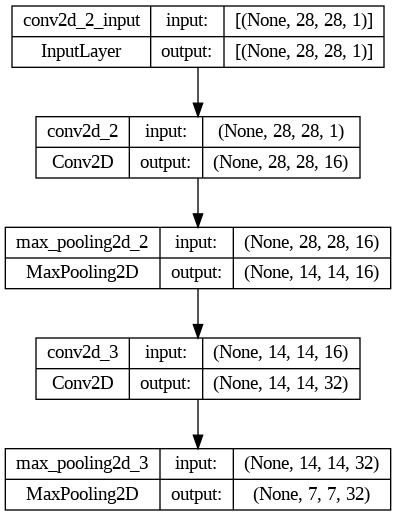

In [ ]:
conv_enc.summary()
tf.keras.utils.plot_model(conv_enc, 'conv_enc.png', show_shapes=True)

Model: "sequential_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_transpose_3 (Conv2DT  (None, 7, 7, 32)         9248      
 ranspose)                                                       
                                                                 
 up_sampling2d_2 (UpSampling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 conv2d_transpose_4 (Conv2DT  (None, 14, 14, 16)       4624      
 ranspose)                                                       
                                                                 
 up_sampling2d_3 (UpSampling  (None, 28, 28, 16)       0         
 2D)                                                             
                                                                 
 conv2d_transpose_5 (Conv2DT  (None, 28, 28, 1)      

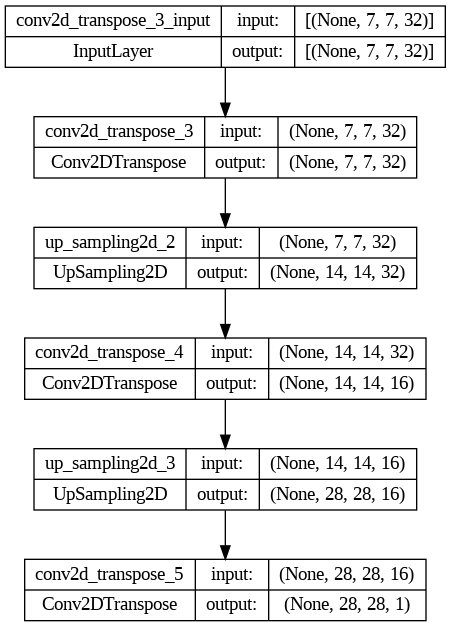

In [ ]:
conv_dec.summary()
tf.keras.utils.plot_model(conv_dec, 'conv_dec.png', show_shapes=True)

Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_29 (Sequential)  (None, 7, 7, 32)          4800      
                                                                 
 sequential_30 (Sequential)  (None, 28, 28, 1)         14017     
                                                                 
Total params: 18,817
Trainable params: 18,817
Non-trainable params: 0
_________________________________________________________________


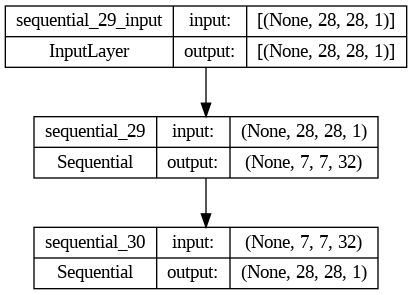

In [ ]:
conv_ae.summary()
tf.keras.utils.plot_model(conv_ae, 'conv_ae.png', show_shapes=True)

# 학습 전 Conv 모델 가시화
- MLP 모델과 비슷하게 정확한 형태를 알아볼 수 없다. 하지만 약간의 형태는 보임

In [ ]:
import ipywidgets as widgets


def train_conv_dataset_imshow(idx):
  print('GT label:', train_labels[idx])

  X      = tf.expand_dims(train_images[idx], 0)  # (28, 28, 1) -> (1, 28, 28, 1)
  Y_pred = conv_ae(X) 

  input_img  = tf.keras.utils.array_to_img(tf.squeeze(X, 0))
  output_img = tf.keras.utils.array_to_img(tf.squeeze(Y_pred, 0))

  plt.subplot(121)
  plt.imshow(input_img, cmap='gray')
  plt.subplot(122)
  plt.imshow(output_img, cmap='gray')
  plt.show()

def train_dataset_conv_imshow(idx):
  print('GT label:', train_labels[idx])

  X      = tf.expand_dims(train_images[idx], 0)  # (28, 28, 1) -> (1, 28, 28, 1)
  Y_pred = conv_ae(X) 

  input_img  = tf.keras.utils.array_to_img(tf.squeeze(X, 0))
  output_img = tf.keras.utils.array_to_img(tf.squeeze(Y_pred, 0))

  plt.subplot(121)
  plt.imshow(input_img, cmap='gray')
  plt.subplot(122)
  plt.imshow(output_img, cmap='gray')
  plt.show()

widgets.interact(train_conv_dataset_imshow, idx=widgets.IntSlider(min=0, max=train_images.shape[0]-1, continuous_update=False));


def test_dataset_conv_imshow(idx):
  print('GT label:', test_labels[idx])

  X      = tf.expand_dims(test_images[idx], 0)  # (28, 28, 1) -> (1, 28, 28, 1)
  Y_pred = conv_ae(X) 

  input_img  = tf.keras.utils.array_to_img(tf.squeeze(X, 0))
  output_img = tf.keras.utils.array_to_img(tf.squeeze(Y_pred, 0))

  plt.subplot(121)
  plt.imshow(input_img, cmap='gray')
  plt.subplot(122)
  plt.imshow(output_img, cmap='gray')
  plt.show()

interactive(children=(IntSlider(value=0, continuous_update=False, description='idx', max=59999), Output()), _d…

# 학습 후 Conv 모델 가시화
- MLP모델과 확연한 차이가 보인다 직선의 형태뿐만 아니라 비교적 복잡한 이미지 또한 유사하게 생성한 것을 확인할 수 있다.

In [ ]:
"""
compile, fit 함수 작성 및 실행

"""

## TODO

from keras.optimizers import Adam

lr = 0.0025  # 학습률 설정
optimizer = Adam(lr=lr)  # Adam optimizer 생성 및 학습률 설정

conv_ae.compile(optimizer=optimizer, # optimizer의 name 혹은 함수 객체 설정
          loss='binary_crossentropy', 
          #  loss='mse', 
           metrics=['accuracy'])

hist = conv_ae.fit(train_images,train_images,epochs=num_epochs ,batch_size=batch_size)
widgets.interact(train_dataset_conv_imshow, idx=widgets.IntSlider(min=0, max=train_images.shape[0]-1, continuous_update=False));

Epoch 1/10


/usr/local/lib/python3.9/dist-packages/keras/optimizers/optimizer_v2/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


600/600 [==============================] - 3s 4ms/step - loss: 0.0991 - accuracy: 0.8128
Epoch 2/10
600/600 [==============================] - 2s 4ms/step - loss: 0.0723 - accuracy: 0.8152
Epoch 3/10
600/600 [==============================] - 2s 4ms/step - loss: 0.0700 - accuracy: 0.8153
Epoch 4/10
600/600 [==============================] - 2s 4ms/step - loss: 0.0689 - accuracy: 0.8154
Epoch 5/10
600/600 [==============================] - 3s 4ms/step - loss: 0.0682 - accuracy: 0.8154
Epoch 6/10
600/600 [==============================] - 2s 4ms/step - loss: 0.0676 - accuracy: 0.8154
Epoch 7/10
600/600 [==============================] - 2s 4ms/step - loss: 0.0672 - accuracy: 0.8154
Epoch 8/10
600/600 [==============================] - 2s 4ms/step - loss: 0.0669 - accuracy: 0.8154
Epoch 9/10
600/600 [==============================] - 2s 4ms/step - loss: 0.0666 - accuracy: 0.8154
Epoch 10/10
600/600 [==============================] - 3s 4ms/step - loss: 0.0664 - accuracy: 0.8154


interactive(children=(IntSlider(value=0, continuous_update=False, description='idx', max=59999), Output()), _d…

In [ ]:
"""
학습된 Convolutional Autoencoder 통과

학습데이터 학습이 완료된 Convolutional Autoencoder모델을 test 데이터셋을 이용하여 Convolutional Autoencoder 통과
evaluate 함수를 이용하여 해당 모델을 평가
input으로 test dataset을 받아서 loss값과 정확도를 반환해준다.

"""

## TODO
test_loss, test_acc = conv_ae.evaluate(test_images, test_images)
# predictions = conv_ae.predict(test_images)

313/313 [==============================] - 1s 3ms/step - loss: 0.0659 - accuracy: 0.8145


Test Accuracy: 0.8144623637199402


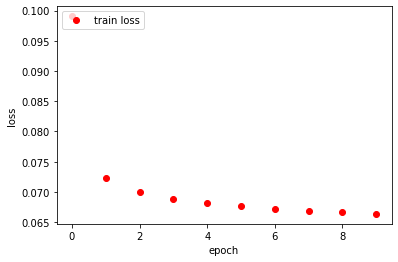

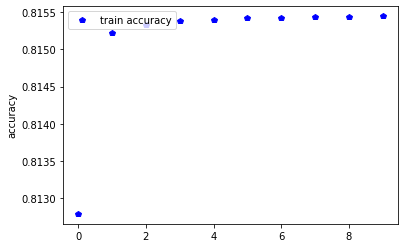

interactive(children=(IntSlider(value=0, continuous_update=False, description='idx', max=9999), Output()), _do…

In [ ]:
"""
Convolutional VAE 결과 확인
"""

## TODO

print("Test Accuracy:", test_acc)

fig, loss_ax = plt.subplots()
gix, acc_ax = plt.subplots()

loss_ax.plot(hist.history['loss'], 'ro', label = 'train loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='upper left')

acc_ax.plot(hist.history['accuracy'], 'bp', label = 'train accuracy')
acc_ax.set_ylabel('accuracy')
acc_ax.legend(loc='upper left')

plt.show()


import ipywidgets as widgets

widgets.interact(test_dataset_conv_imshow, idx=widgets.IntSlider(min=0, max=test_images.shape[0]-1, continuous_update=False));

# 최종 마무리 분석

1. 처음 잠재 공간 z의 차원을 다양하게 바꾸면서 discriminative한 representation을 만들어내는지 확인해봤다.
- 2차원 + 초기값 Xavier : 해당 라벨들이 골고루 분포되어 있음
- 2차원 + 초기값 He : 이전 방법 비슷하지만 약간 더 넓게 분포되어 있는 느낌
- 4차원 + 초기값 He : 시각화 단계에서 분포가 상당히 밀집되어 있는걸 확인
- 8차원 + 초기값 He : 이전 단계보다 더욱 더 밀집되어 있음
결론 : 시각화의 문제일 수 있지만 차원이 높을수록 더욱 밀집되어 있는걸 확인할 수 있었고 뿐만 아니라 초기값은 Xavier을 주는게 분포가 가장 균일했다.

2. MLP 모델 VS Conv 모델
- MLP : 랜덤으로 뽑은 시각화에서 볼 수 있듯 직선의 단조로운 형태의 특징은 잘 잡아내는 반면 연속된 곡선이 있는 조금 더 복잡한 특징의 이미지는 제대로 생성하지 못하는 걸 확인해볼 수 있었다.
- Conv : Enc 레이어와 Dec 레이어를 2개씩 얇게 쌓았음에도 해당 MLP모델보다 더욱 더 유사한 이미지가 생성되는 것을 확인할 수 있었다. MLP 모델과의 또 다른 차이점은 손실함수로 MSE가 아닌 Binary Cross entropy를 사용한다는 점이다.

결론 : 해당 Task가 이미지를 생성하는 Task이다 보니 일반적인 MLP모델보다 Conv모델을 사용하는게 더욱 더 좋은 이미지를 생성하는 것을 확인할 수 있었다.